# Physical, Subarray Beamformer testing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from scipy.signal import resample
from scipy.signal import butter, lfilter, lfilter_zi
from playsound import playsound
from os import listdir
from os.path import isfile, join

### Array Parameters

In [3]:
fs = 48000 # audio sampling frequency
f1 = 570
f2 = 850 # band limits of each sub-array
filter_order = 5

array_loc = np.array([5, 0]) # x/y location of array center
N = 1024 # fft length - defines N/2 + 1 frequency bands
n_mics = 8 # number of microphones

# sub-array 1: 5 mics, 8cm apart
n1 = 5 # number of microphones
sep1 = 0.08 # microphone separation
R1 = pra.linear_2D_array(center=array_loc+[0.08, 0], M=n1, phi=0, d=sep1) # sub-array is offset from center
array1 = pra.Beamformer(R1, fs, N)

# sub-array 2: 4 mics, 16cm apart
n2 = 4 # number of microphones
sep2 = 0.16 # microphone separation
R2 = pra.linear_2D_array(center=array_loc, M=n2, phi=0, d=sep2)
array2 = pra.Beamformer(R2, fs, N)

# sub-array 3: 5 mics, 24cm apart
n3 = 5 # number of microphones
sep3 = 0.24 # microphone separation
R3 = pra.linear_2D_array(center=array_loc, M=n3, phi=0, d=sep3)
array3 = pra.Beamformer(R3, fs, N)

frequencies = array1.frequencies
freq_idx1 = np.argmax(frequencies > f2)
freq_idx2 = np.argmax(frequencies > f1)
arrays = [array1, array2, array3]

### Load Recorded Signals

Stores them in the beamformer object

In [4]:
mic_signals_folder = '../array_samples/bf_testing_12_10_24/Sines 1'
mic_signals_filenames = [f for f in listdir(mic_signals_folder) if isfile(join(mic_signals_folder, f))]
mic_signals_filenames.sort()

for i in range(n_mics):
    file_str = mic_signals_folder + '/' + mic_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        mic_signals = np.zeros((n_mics, len(audio)))

    mic_signals[n_mics-1-i, :] = audio

# load specific signals into specific mics for arrays
array1.signals = mic_signals[[1,2,3,4,5],:]
array2.signals = mic_signals[[1,3,5,6],:]
array3.signals = mic_signals[[0,1,4,6,7],:]

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_43119/3314393953.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


In [5]:
# compute noise covariance matrix from room
room_signals_folder = '../array_samples/bf_testing_12_10_24/Room'
room_signals_filenames = [f for f in listdir(room_signals_folder) if isfile(join(room_signals_folder, f))]
room_signals_filenames.sort()

for i in range(n_mics):
    file_str = room_signals_folder + '/' + room_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        room_signals = np.zeros((n_mics, len(audio)))

    # audio = (audio/2**32)

    room_signals[n_mics-1-i, :] = audio

snapshot = room_signals[:, :] # adjust length of noise snapshot if necessary
snapshot1 = snapshot[[1,2,3,4,5],:]
snapshot2 = snapshot[[1,3,5,6],:]
snapshot3 = snapshot[[0,1,4,6,7],:]

diag_loading = 1e8 # ensures nonzero eigenvalues
R_n1 = (1.0/snapshot1.shape[1]) * np.cov(snapshot1) + diag_loading * (np.eye(n1))
R_n2 = (1.0/snapshot2.shape[1]) * np.cov(snapshot2) + diag_loading * (np.eye(n2))
R_n3 = (1.0/snapshot3.shape[1]) * np.cov(snapshot3) + diag_loading * (np.eye(n3))
print(R_n1)

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_43119/3500806297.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


[[1.34927600e+08 2.24895662e+07 3.61115966e+07 4.48621113e+07
  3.85840282e+07]
 [2.24895662e+07 1.27797368e+08 3.50173303e+07 3.63781093e+07
  3.00132105e+07]
 [3.61115966e+07 3.50173303e+07 1.51874375e+08 5.58264440e+07
  4.53801735e+07]
 [4.48621113e+07 3.63781093e+07 5.58264440e+07 1.64492808e+08
  5.36237505e+07]
 [3.85840282e+07 3.00132105e+07 4.53801735e+07 5.36237505e+07
  1.47043980e+08]]


### Isolate sources with beamforming

source 1 SINR: 12.147017357866918
source 2 SINR: 12.378144292854646


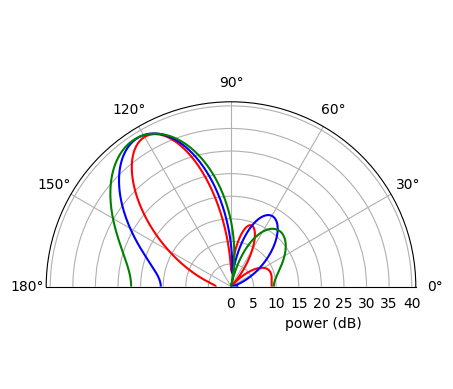

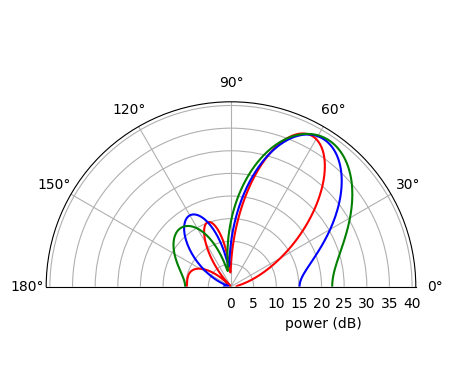

In [6]:
# add guessed locations of sources to room
n_source = 2
doa_azimuths = np.array([np.arctan2(2,-1), np.arctan2(2,1)]) # ground truth
# doa_azimuths = np.array([55.86206897, 93.10344828])*np.pi/180.0 # DOA estimate

# add guessed locations of sources to room
guess_dist = 3 # fixed guess distance away from array
guess_source_locs = np.empty((2, n_source))

for i in range(n_source):
    guess_source_locs[0, i] = array_loc[0] + guess_dist*np.cos(doa_azimuths[i])
    guess_source_locs[1, i] = array_loc[1] + guess_dist*np.sin(doa_azimuths[i])

# Beamforming algorithm for each source
out_filepath = '../output_samples/physical_tests'

for i in range(guess_source_locs.shape[1]):
    current_interferers = guess_source_locs
    current_interferers = np.delete(current_interferers, i, 1)

    interf = pra.soundsource.SoundSource([0, 0])
    interf.images = current_interferers

    source = pra.soundsource.SoundSource([0, 0])
    source.images = np.array([[guess_source_locs[0, i]], [guess_source_locs[1, i]]])

    # beamform for each sub-array
    array1.rake_max_sinr_weights(
        source=source,
        interferer=interf,
        R_n=R_n1
    )
    array2.rake_max_sinr_weights(
        source=source,
        interferer=interf,
        R_n=R_n2
    )
    array3.rake_max_sinr_weights(
        source=source,
        interferer=interf,
        R_n=R_n3
    )

    array1.filters_from_weights()
    array2.filters_from_weights()
    array3.filters_from_weights()

    # compute SIR, averaged across all frequency bands
    SIR_sum = 0
    for f in arrays[0].frequencies[freq_idx1:]:
        current_SIR = arrays[0].snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR

    for f in arrays[1].frequencies[freq_idx2:freq_idx1]:
        current_SIR = arrays[1].snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR


    for f in arrays[2].frequencies[:freq_idx2]:
        current_SIR = arrays[2].snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR

    print(f'source {i+1} SINR: {SIR_sum / len(array1.frequencies)}')

    # generate beam pattern plot
    phis = np.arange(0,181)*np.pi/180
    response1 = array1.response(phis, 1500)
    mag_response1 = abs(response1[1])

    response2 = array2.response(phis, 750)
    mag_response2 = abs(response2[1])

    response3 = array3.response(phis, 325)
    mag_response3 = abs(response3[1])

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(phis, mag_response1, 'r-')
    ax.plot(phis, mag_response2, 'b-')
    ax.plot(phis, mag_response3, 'g-')
    ax.set_xlim([0, np.pi])
    ax.set_xlabel('power (dB)')
    ax.xaxis.set_label_coords(0.75, 0.17)

    # process audio
    output1 = array1.process()
    output2 = array2.process()
    output3 = array3.process()

    # filter processed audio to only include useful frequencies
    b1, a1 = butter(filter_order, f1, 'lowpass', fs=fs)
    b2, a2 = butter(filter_order, [f1, f2], 'bandpass', fs=fs)
    b3, a3 = butter(filter_order, f2, 'highpass', fs=fs)
    z1 = lfilter_zi(b1, a1)
    z2 = lfilter_zi(b2, a2)
    z3 = lfilter_zi(b3, a3)

    filtered1 = lfilter(b1, a1, output1, zi=z1*output1[0])
    filtered2 = lfilter(b2, a2, output2, zi=z2*output2[0])
    filtered3 = lfilter(b3, a3, output3, zi=z3*output3[0])

    filtered1_norm = pra.normalize(filtered1[0])
    filtered2_norm = pra.normalize(filtered2[0])
    filtered3_norm = pra.normalize(filtered3[0])

    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '_array_1.wav', fs, filtered1_norm)
    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '_array_2.wav', fs, filtered2_norm)
    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '_array_3.wav', fs, filtered3_norm)

    output = filtered1[0] + filtered2[0] + filtered3[0]
    out_norm = pra.normalize(output)
    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '.wav', fs, out_norm)

# plt.plot(output)

### Evaluate performance

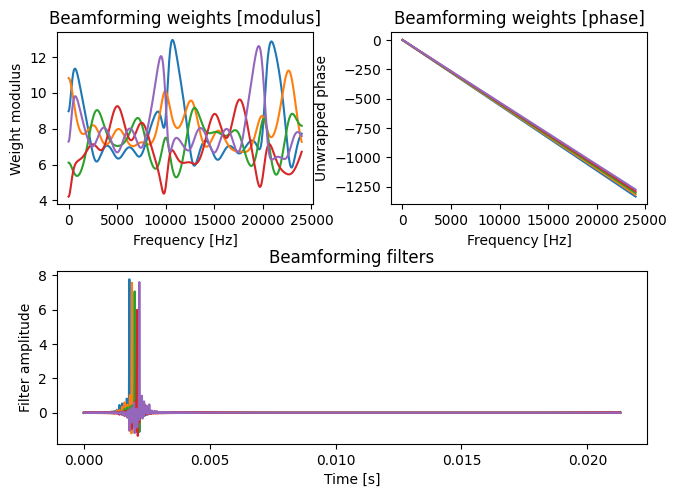

In [7]:
# plot beamformer info
array1.plot(FD=True)